In [1]:
# %pip install torch pandas transformers scikit-learn matplotlib nltk pymorphy2 pymorphy2-dicts-uk

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from preprocessing import (get_x, 
                           get_y, 
                           get_vocab_size, 
                           tokenize_x, 
                           tokenize_titles,
                           balance_data, 
                           create_dictionary, 
                           lemmatize_word, 
                           is_not_punctuation, 
                           cat_titles_and_texts,
                           get_x1)

In [3]:
# import nltk
# nltk.download('punkt')

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU instead.")

Using GPU: NVIDIA A10G


In [5]:
df = pd.read_csv("translated.csv")
x = get_x(df)
y = get_y(df)
x_titles = get_x1(df)


In [6]:
df_zepopo = balance_data(pd.read_csv("data_set_4.csv"))
# df_zepopo = pd.read_csv("data_set_4.csv")
# df_zepopo = df_zepopo.sample(frac=1).iloc[::4]
print(len(df_zepopo))
x1 = get_x(df_zepopo)
y1 = get_y(df_zepopo)
x1_titles = get_x1(df_zepopo)

Int64Index([ 706, 5325, 1665, 6675, 5605, 2317, 1691, 5030,  318, 3745,
            ...
            6500,  422, 1220, 3439, 3877, 7724, 6732,  102, 2418, 7796],
           dtype='int64', length=2498)
4913


In [7]:
df_realdata = pd.read_csv("new_real_news.csv")
print(len(df_realdata))
x2 = get_x(df_realdata)
y2 = get_y(df_realdata)
x2_titles = get_x1(df_realdata)

1188


In [8]:
# merging two datasets together
x += x1
x += x2

y += y1
y += y2

x_titles += x1_titles
x_titles += x2_titles

x = cat_titles_and_texts(texts=x, titles=x_titles)

In [9]:
y = torch.tensor(y, dtype=torch.float).view(-1, 1) 

In [10]:
import json
# loading an existing dictionary
with open("dictionary.json", "r", encoding="utf-8") as f:
    dictionary = json.load(f)

# creating a new dicionary
# dictionary = create_dictionary(x + x_titles)
# with open("dictionary.json", "w", encoding="utf-8") as f:
#     json.dump(dictionary, f)

In [11]:
X_train, X_temp, y_train, y_temp = train_test_split(
    x, y, test_size=0.3, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

In [12]:
len(X_train)

9069

In [13]:
X_train_tensor, X_val_tensor, X_test_tensor = torch.LongTensor(tokenize_x(X_train, dictionary=dictionary)), torch.LongTensor(tokenize_x(X_val, dictionary=dictionary)), torch.LongTensor(tokenize_x(X_test, dictionary=dictionary))

In [14]:
print(device)

cuda


In [15]:
print(X_test_tensor[0])

tensor([88846, 23275,     0,     0,  4929,     0,  9731, 43663,     0, 47337,
         5455,  7119,  1371,  8650,     0,  3046,  4997, 47339,     0,  5133,
            5,  6051,     0,  6330,     0,     0, 23275,     0, 10604,     0,
            0, 14838,  1578,  4980,  4911,     0, 26926,     0,  4313,  4980,
        47339,  9430,     0,  1191, 43663,     0,     0,     0, 47344, 41629,
        47345,  9731,  1771,     0,     0, 26926,  9402, 47099,     0,  4997,
        23275, 47347,  2198,  5371,     0,     0,     0, 47350,     0,     0,
            0,     0,  3046, 47337,  5455,  1022, 43663, 47339,  1771,  2942,
         1191,     0,     0,  9731, 29674,     0, 41629, 47347,  2198,     0,
            0, 47354,     0, 47355,     0,  5963, 13859,  4980,     0, 40110,
         2942,     0, 43102,  5133,     0,     0,  2557, 47356,  7944, 47357,
         1009, 41729, 47344, 41629,  6049,  2653,     0,  9290, 15653,     0,
            0,  4997, 43663,    85,     0,  4235,     0, 15387, 

In [16]:
print(X_train_tensor.size())

torch.Size([9069, 150])


In [17]:
# making sure the dataset is balanced
print("real news")
print(len([i for i in y if i == 0]))
print("fake news")
print(len([i for i in y if i == 1]))

real news
7083
fake news
5873


In [18]:
X_train_tensor = X_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)

y_train = y_train.to(device)
y_val = y_val.to(device)
y_test = y_test.to(device)


In [19]:
# class LSTMClassifier(nn.Module):
#     def __init__(self, 
#                  vocab_size, 
#                  embedding_dim, 
#                  hidden_dim, 
#                  output_dim, 
#                  num_layers, 
#                  bidirectional, 
#                  dropout):
        
#         super().__init__()
#         self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
#         self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, 
#                             bidirectional=bidirectional, dropout=dropout, batch_first=True)
        
        
#         # output layer
# #         total_hidden_dim = hidden_dim * 2 if bidirectional else hidden_dim
#         hidden_dim = hidden_dim * 2 if bidirectional else hidden_dim
#         self.fc = nn.Linear(hidden_dim, output_dim)
#         self.act = nn.Sigmoid()

#     def forward(self, x):
        
#         x_embedded = self.embedding(x)
        
#         _, (hidden_x, _) = self.lstm(x_embedded)

        
#         if self.lstm.bidirectional:
#             hidden_x = torch.cat((hidden_x[-2,:,:], hidden_x[-1,:,:]), dim=1)
#         else:
#             hidden_x = hidden_x[-1,:,:]

#         output = self.fc(hidden_x)
#         return self.act(output)

In [20]:
class LSTMClassifier(nn.Module):
    def __init__(self, 
                 vocab_size, 
                 embedding_dim, 
                 hidden_dim, 
                 output_dim, 
                 num_layers, 
                 bidirectional, 
                 dropout):
        
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, 
                            bidirectional=bidirectional, dropout=dropout, batch_first=True)
        
        # Adjusting hidden_dim based on whether the LSTM is bidirectional
        hidden_dim = hidden_dim * 2 if bidirectional else hidden_dim
        
        # Adding two additional fully connected layers
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc2 = nn.Linear(hidden_dim // 2, hidden_dim // 4)

        # Output layer remains the same
        self.fc3 = nn.Linear(hidden_dim // 4, output_dim)
        self.act = nn.Sigmoid()

    def forward(self, x):
        
        x_embedded = self.embedding(x)
        
        _, (hidden_x, _) = self.lstm(x_embedded)

        # Handling the output of the bidirectional LSTM
        if self.lstm.bidirectional:
            hidden_x = torch.cat((hidden_x[-2,:,:], hidden_x[-1,:,:]), dim=1)
        else:
            hidden_x = hidden_x[-1,:,:]

        # Passing through the fully connected layers
        hidden_x = torch.relu(self.fc1(hidden_x))
        hidden_x = torch.relu(self.fc2(hidden_x))

        output = self.fc3(hidden_x)
        return self.act(output)


In [21]:
vocab_size = get_vocab_size(x)
print(vocab_size)
embedding_dim = len(X_train_tensor[0])
print(embedding_dim)
output_dim = 1
hidden_dim = 32
hidden_dim_titles = 16
num_layers = 3
learning_rate=0.0005
dropout = 0.0
num_epochs = 2000
bidirectional = True

169915
150


In [22]:
model = LSTMClassifier(vocab_size=vocab_size,
                       embedding_dim=embedding_dim,
                       hidden_dim=hidden_dim, 
                       output_dim=output_dim, 
                       num_layers=num_layers,
                       bidirectional=bidirectional, 
                       dropout=dropout)
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [23]:
from sklearn.metrics import accuracy_score

In [24]:
import numpy as np

best_loss = float('inf')
best_epoch = 0
accuracies_train = []
accuracies_val = []
losses_train = []
losses_val = []

patience = 50
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    print(outputs)
    
    # loss
    loss = criterion(outputs, y_train)
    losses_train.append(loss.item())  # Logging the loss value
    loss.backward()
    optimizer.step()

    # accuracy (need to move tensors to CPU before converting to NumPy)
    with torch.no_grad():
        predicted = (outputs >= 0.5).squeeze().long()
        accuracy = accuracy_score(y_train.cpu().numpy(), predicted.cpu().numpy())
        accuracies_train.append(accuracy)
    
    # validation
    model.eval()
    val_outputs = model(X_val_tensor)

    # val loss
    val_loss = criterion(val_outputs, y_val)
    losses_val.append(val_loss.item())  # Logging the validation loss value

    # val accuracy (move to CPU and convert to NumPy)
    with torch.no_grad():
        predicted_val = (val_outputs >= 0.5).squeeze().long()
        accuracy_val = accuracy_score(y_val.cpu().numpy(), predicted_val.cpu().numpy())
        accuracies_val.append(accuracy_val)
    
    if val_loss < best_loss:
        best_loss = val_loss
        best_epoch = epoch
        best_weights = model.state_dict()
        patience_counter = 0  # Reset patience counter on improvement
    else:
        patience_counter += 1
    
    print(f"Epoch: {epoch+1}/{num_epochs}, Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}")

    if patience_counter >= patience:
        print("Early stopping triggered")
        break
    
print("Best epoch: ", best_epoch)


tensor([[0.4917],
        [0.4919],
        [0.4919],
        ...,
        [0.4921],
        [0.4912],
        [0.4917]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Epoch: 1/2000, Training Loss: 0.6917312741279602, Validation Loss: 0.6912494897842407
tensor([[0.4907],
        [0.4908],
        [0.4907],
        ...,
        [0.4908],
        [0.4902],
        [0.4905]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Epoch: 2/2000, Training Loss: 0.6915320158004761, Validation Loss: 0.6910712718963623
tensor([[0.4898],
        [0.4900],
        [0.4898],
        ...,
        [0.4899],
        [0.4894],
        [0.4896]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Epoch: 3/2000, Training Loss: 0.6913819313049316, Validation Loss: 0.6909060478210449
tensor([[0.4890],
        [0.4892],
        [0.4889],
        ...,
        [0.4890],
        [0.4886],
        [0.4888]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Epoch: 4/2000, Training Loss: 0.6912398934364319, Validation Loss: 0.69074

Epoch: 34/2000, Training Loss: 0.6875505447387695, Validation Loss: 0.6868287920951843
tensor([[0.4682],
        [0.4683],
        [0.4685],
        ...,
        [0.4680],
        [0.4690],
        [0.4673]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Epoch: 35/2000, Training Loss: 0.6873409748077393, Validation Loss: 0.6866651773452759
tensor([[0.4684],
        [0.4684],
        [0.4687],
        ...,
        [0.4681],
        [0.4693],
        [0.4674]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Epoch: 36/2000, Training Loss: 0.6871113777160645, Validation Loss: 0.6864914894104004
tensor([[0.4685],
        [0.4686],
        [0.4690],
        ...,
        [0.4683],
        [0.4696],
        [0.4675]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Epoch: 37/2000, Training Loss: 0.6868615746498108, Validation Loss: 0.6863035559654236
tensor([[0.4687],
        [0.4688],
        [0.4693],
        ...,
        [0.4685],
        [0.4700],
        [0.4676]], device='cuda:0', grad_fn=<Sig

Epoch: 67/2000, Training Loss: 0.6167950630187988, Validation Loss: 0.636014461517334
tensor([[0.5925],
        [0.4511],
        [0.4469],
        ...,
        [0.4402],
        [0.5977],
        [0.4405]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Epoch: 68/2000, Training Loss: 0.6095073819160461, Validation Loss: 0.6318345665931702
tensor([[0.6072],
        [0.4467],
        [0.4436],
        ...,
        [0.4386],
        [0.6118],
        [0.4391]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Epoch: 69/2000, Training Loss: 0.6016882658004761, Validation Loss: 0.6278268098831177
tensor([[0.6226],
        [0.4433],
        [0.4413],
        ...,
        [0.4370],
        [0.6265],
        [0.4377]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Epoch: 70/2000, Training Loss: 0.5933995246887207, Validation Loss: 0.6239832639694214
tensor([[0.6386],
        [0.4403],
        [0.4391],
        ...,
        [0.4355],
        [0.6419],
        [0.4364]], device='cuda:0', grad_fn=<Sigm

Epoch: 100/2000, Training Loss: 0.3411194980144501, Validation Loss: 0.6232653856277466
tensor([[0.9623],
        [0.3286],
        [0.3278],
        ...,
        [0.3271],
        [0.9619],
        [0.3284]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Epoch: 101/2000, Training Loss: 0.33493050932884216, Validation Loss: 0.6304642558097839
tensor([[0.9643],
        [0.3234],
        [0.3222],
        ...,
        [0.3210],
        [0.9639],
        [0.3227]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Epoch: 102/2000, Training Loss: 0.3285638689994812, Validation Loss: 0.6344407200813293
tensor([[0.9662],
        [0.3180],
        [0.3169],
        ...,
        [0.3153],
        [0.9657],
        [0.3168]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Epoch: 103/2000, Training Loss: 0.3225076496601105, Validation Loss: 0.6240664124488831
tensor([[0.9676],
        [0.3115],
        [0.3109],
        ...,
        [0.3096],
        [0.9673],
        [0.3110]], device='cuda:0', grad_fn

Epoch: 133/2000, Training Loss: 0.17962546646595, Validation Loss: 0.6939786076545715
tensor([[0.9862],
        [0.1398],
        [0.1397],
        ...,
        [0.1385],
        [0.9866],
        [0.1390]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Epoch: 134/2000, Training Loss: 0.17682282626628876, Validation Loss: 0.7091299295425415
tensor([[0.9866],
        [0.1354],
        [0.1352],
        ...,
        [0.1340],
        [0.9869],
        [0.1345]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Epoch: 135/2000, Training Loss: 0.1746784746646881, Validation Loss: 0.6984441876411438
tensor([[0.9868],
        [0.1307],
        [0.1309],
        ...,
        [0.1297],
        [0.9871],
        [0.1302]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Epoch: 136/2000, Training Loss: 0.17220519483089447, Validation Loss: 0.6991239190101624
Early stopping triggered
Best epoch:  85


In [25]:
if best_weights is not None:
    model.load_state_dict(best_weights)

In [26]:
print(accuracies_train[best_epoch],
accuracies_val[best_epoch],
losses_train[best_epoch],
losses_val[best_epoch])

0.8989965817620466 0.7529593412249099 0.44153115153312683 0.5975863337516785


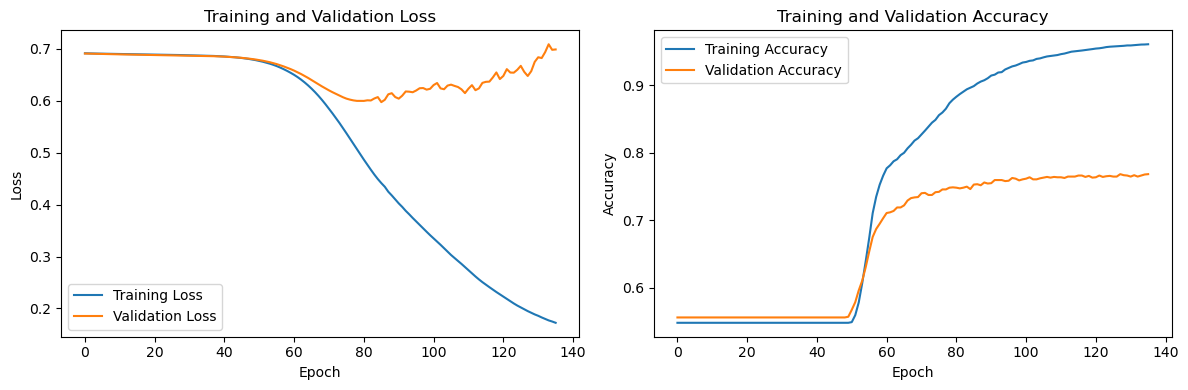

In [27]:
# lists to tensors
losses_train = torch.tensor(losses_train)
losses_val = torch.tensor(losses_val)
accuracies_train = torch.tensor(accuracies_train)
accuracies_val = torch.tensor(accuracies_val)

# training and validation losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(losses_train.detach().numpy(), label='Training Loss')
plt.plot(losses_val.detach().numpy(), label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(accuracies_train.detach().numpy(), label='Training Accuracy')
plt.plot(accuracies_val.detach().numpy(), label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [28]:
from sklearn.metrics import (precision_score, recall_score, f1_score)

In [29]:
test_outputs = model(X_test_tensor)
test_outputs = (test_outputs >= 0.5).squeeze().long()

In [30]:
test_outputs = test_outputs.cpu().numpy()
y_test = y_test.cpu().numpy()

In [31]:
test_accuracy = accuracy_score(y_test, test_outputs)
test_precision = precision_score(y_test, test_outputs)
test_recall = recall_score(y_test, test_outputs)
test_f1 = f1_score(y_test, test_outputs)

In [32]:
print("Accuracy:", test_accuracy)
print("Precision:", test_precision)
print("Recall:", test_recall)
print("f1:", test_f1)

Accuracy: 0.7649176954732511
Precision: 0.7870722433460076
Recall: 0.6824175824175824
f1: 0.7310182460270748


test dataset (87 texts)

In [33]:
import json
with open("test_set.json", "r", encoding="utf-8") as f: 
    test_texts = json.load(f)

fake_texts = [t["text"] for t in test_texts if t["label"] == "Fake"]
fake_titles = [t["title"] for t in test_texts if t["label"] == "Fake"]
real_texts = [t["text"] for t in test_texts if t["label"] == "Real"]
real_titles = [t["text"] for t in test_texts if t["label"] == "Real"]

In [34]:
print(len(fake_texts), len(real_texts))

42 36


In [35]:
df = pd.DataFrame(columns = ["ukr_text", "label", "title_ukr"])
for i, text in enumerate(fake_texts): 
    df.loc[i] = {
        "ukr_text": text, 
        "label": "Fake", 
        "title_ukr": fake_titles[i]
    }

for i, text in enumerate(real_texts): 
    df.loc[i+42] = {
        "ukr_text": text, 
        "label": "Real", 
        "title_ukr": real_titles[i]
    }

In [36]:
# df

In [37]:
len(df)

78

In [38]:
test_data_x = torch.LongTensor(tokenize_x(cat_titles_and_texts(texts=get_x(df), titles=get_x1(df)), dictionary=dictionary))
test_data_y = torch.tensor(get_y(df), dtype=torch.float).view(-1, 1).cpu()

In [39]:
test_data_x = test_data_x.to(device)
# test_data_y = test_data_x.cpu()

In [40]:
test_outputs = model(test_data_x)
test_outputs = (test_outputs >= 0.5).squeeze().long()

In [41]:
test_outputs

tensor([1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0], device='cuda:0')

In [42]:
test_outputs = test_outputs.cpu().numpy()
test_data_y = test_data_y.cpu().numpy()

In [43]:
test_accuracy = accuracy_score(test_data_y, test_outputs)
test_precision = precision_score(test_data_y, test_outputs)
test_recall = recall_score(test_data_y, test_outputs)
test_f1 = f1_score(test_data_y, test_outputs)

In [44]:
print(test_accuracy, test_precision, test_recall, test_f1)

0.6666666666666666 0.8076923076923077 0.5 0.6176470588235294


In [45]:
# model.to("cpu")
# model_scripted = torch.jit.script(model)
# model_scripted.save('lstm.pt')
# torch.save(model, 'lstm_with_zepopo_32_without_markers_with_titles.pth')

#### 